In [1]:
import pandas as pd
import numpy as np
import string

df = pd.read_csv("../data/fulldata.csv")
df2 = pd.read_csv("../data/6_14_pull.csv")

df = pd.concat([df,df2])

In [2]:
from Cleaning import lowercase, unpunctuate, tokenize, lemmatize, count_capitalized_words, create_other_var, cleaning_and_prep, stack_vectors

In [3]:
X_train, X_test, y_train, y_test = cleaning_and_prep(df)

C:\Users\Andrew\Documents\LHL\PoliticalNLP\python\Cleaning.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Political Lean'] = df['Political Lean'].replace('Liberal',1)
C:\Users\Andrew\Documents\LHL\PoliticalNLP\python\Cleaning.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Political Lean'] = df['Political Lean'].replace('Conservative',0)


In [4]:
X_train_vec, X_test_vec, X_train, X_test, scaler, train_mask, test_mask = stack_vectors(X_train,X_test)

In [25]:
train_mask.shape

(24056, 60)

Epoch 1/150
752/752 [==============================] - 103s 134ms/step - loss: 0.6301 - accuracy: 0.6358 - auc: 0.6968 - val_loss: 0.6158 - val_accuracy: 0.6630 - val_auc: 0.7377
Epoch 2/150
752/752 [==============================] - 103s 137ms/step - loss: 0.5905 - accuracy: 0.6720 - auc: 0.7484 - val_loss: 0.5993 - val_accuracy: 0.6795 - val_auc: 0.7665
Epoch 3/150
752/752 [==============================] - 99s 131ms/step - loss: 0.5675 - accuracy: 0.6953 - auc: 0.7736 - val_loss: 0.5961 - val_accuracy: 0.6785 - val_auc: 0.7705
Epoch 4/150
752/752 [==============================] - 99s 132ms/step - loss: 0.5549 - accuracy: 0.7058 - auc: 0.7866 - val_loss: 0.5615 - val_accuracy: 0.7176 - val_auc: 0.7957
Epoch 5/150
752/752 [==============================] - 101s 134ms/step - loss: 0.5368 - accuracy: 0.7182 - auc: 0.8018 - val_loss: 0.5460 - val_accuracy: 0.7280 - val_auc: 0.8056
Epoch 6/150
752/752 [==============================] - 98s 131ms/step - loss: 0.5262 - accuracy: 0.7257 - a

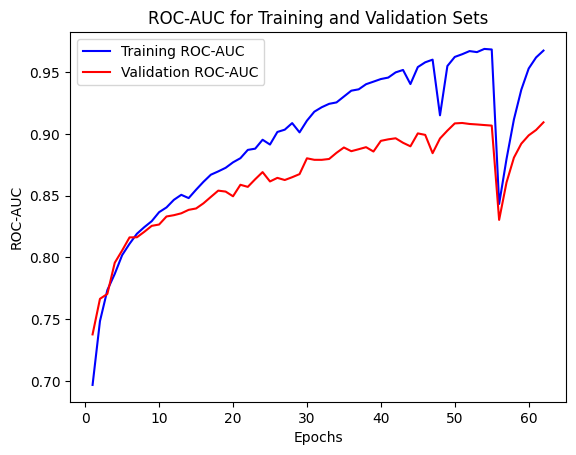

<Axes: >

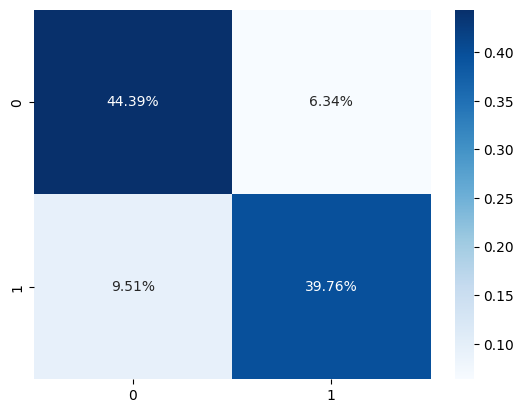

In [33]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, LSTM, Dropout, Input, concatenate, Masking
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from sklearn.metrics import roc_auc_score, accuracy_score
import matplotlib.pyplot as plt

dropout=0.05
lstm_units = 256
lstm_units2 = 128
dense_units = 64


# First branch for the LSTM
lstm_input = Input(shape=(60, 100))
lstm_output = Masking(mask_value=0.0)(lstm_input)  # Apply mask
lstm_output = LSTM(units=lstm_units, return_sequences=True, activation='relu')(lstm_output)
lstm_output = Dropout(dropout)(lstm_output)
lstm_output = LSTM(units=lstm_units2, activation='relu')(lstm_output)
lstm_output = Dropout(dropout)(lstm_output)

# Second branch for the dense layers
dense_input = Input(shape=(5,))
dense_output = Dense(units=dense_units, activation='relu')(dense_input)
dense_output = Dropout(dropout)(dense_output)

# Concatenate the outputs from both branches
combined = concatenate([lstm_output, dense_output])

combined = Dense(units = dense_units, activation='relu')(combined)

# Final output layer
output = Dense(units=1, activation='sigmoid')(combined)

# Create the model
model = Model(inputs=[lstm_input, dense_input], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy', 'AUC'])

# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Train the model with both LSTM and dense input
history = model.fit([X_train_vec, X_train], y_train, epochs=150, batch_size=32,
          validation_data=([X_test_vec, X_test], y_test),
          callbacks=[early_stopping])

# Predict and evaluate
y_pred = model.predict([X_test_vec, X_test])
roc_auc = roc_auc_score(y_test, y_pred)

y_pred_class = (y_pred > .5).astype(int)
accuracy = accuracy_score(y_test,y_pred_class)
print('ROC-AUC:', roc_auc)
print('Accuracy:', accuracy)

# Get the ROC-AUC values for training and validation sets
train_roc_auc = history.history['auc']
val_roc_auc = history.history['val_auc']

# Plot ROC-AUC for training and validation sets
epochs = range(1, len(train_roc_auc) + 1)

plt.plot(epochs, train_roc_auc, 'b', label='Training ROC-AUC')
plt.plot(epochs, val_roc_auc, 'r', label='Validation ROC-AUC')
plt.title('ROC-AUC for Training and Validation Sets')
plt.xlabel('Epochs')
plt.ylabel('ROC-AUC')
plt.legend()
plt.show()

from sklearn.metrics import confusion_matrix
import seaborn as sns

matrix = confusion_matrix(y_test, y_pred_class)

sns.heatmap(matrix/np.sum(matrix), annot=True, fmt='.2%', cmap='Blues')

In [7]:
import numpy as np
import pandas as pd
from imblearn.over_sampling import RandomOverSampler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec

#create extra variables for later
df_other_var = create_other_var(df)

#Create simple dataframe with only text and predictor
df = df[['Title','Political Lean']] 

#dummy code predictor
df['Political Lean'] = df['Political Lean'].replace('Liberal',1)
df['Political Lean'] = df['Political Lean'].replace('Conservative',0)

df = df.rename({'Political Lean':'y'},axis=1) #replace column name for simplicity

df = pd.concat([df,df_other_var],axis=1)

df = df[df['Length']>=15]

#Split into X & y
X = df.drop(['y'],axis=1)
y = df['y']

#oversample minority class
oversample = RandomOverSampler(sampling_strategy='minority', random_state=13)
X, y = oversample.fit_resample(X, y)
X, y = shuffle(X,y, random_state=13)

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
X_train_text, X_test_text, y_train_text, y_test_text = train_test_split(X,y, test_size=.15, random_state = 13)

In [10]:
predictions = pd.DataFrame(y_pred, columns = ['prob'])
loss_df = pd.concat([X_test_text,predictions.set_index(X_test_text.index)],axis=1)
loss_df = pd.concat([loss_df,y_test_text],axis=1)
loss_df['prob'] = abs(loss_df['prob']-.5)

In [11]:
#dropping duplicates due to oversampling
pd.set_option('display.max_colwidth', None)
loss_df.drop_duplicates(subset='Title').sort_values(by='prob').tail(50)

,Title,Upvotes,Comments,Length,Capitals,prob,y
3972,"Unions are not only good for workers, they’re good for communities and for democracy: High unionization levels are associated with positive outcomes across multiple indicators of economic, personal, and democratic well-being",276,7,224,2,0.495591,1
15178,A sticker in NYC's 1989 Pride Parade remembering Stonewall riots,1086,6,64,4,0.495609,1
1523,"The ""American Dream"" is just a shitily disguised pyramid scheme.",2007,68,64,3,0.495649,1
17346,After a parent complained about 'pornographic content' a Utah school district removed the Bible from schools' shelves. The inevitable absurdity of Republican book bans,655,30,167,5,0.496141,1
28275,"We need to stop blaming capitalism for unemployment and low wages and trying to dismantle it. Instead we need to focus our energy on educating people on how to pick a degree that will be useful, develop hard skills, and how to gain experience through internships and other methods.",42,110,281,2,0.496164,0
17468,Republicans Around the Country Are Trying to Rob Democrats of the Right to Govern: It’s not just Ron DeSantis. The red-state war on blue cities is intensifying.,523,29,160,13,0.496220,1
6927,"The IRS should police wealthy Americans who intentionally dodge their income taxes with more vigor, according to a report from the Treasury Inspector General. About 686,000 taxpayers who earn at least $200,000 a year had a combined $38.5 billion tax balance as of mid-May 2019",280,16,276,8,0.496252,1
11116,This guy seriously doesn't understand the system and people believe him,384,601,71,1,0.496478,0
24262,Video: Biden Is Arresting President Trump Because He Can't Beat Him - Here He Is Admitting He Is Going To Do It,0,3,111,21,0.496590,0
1627,"Anti-racist rally in Rio de Janeiro Brazil. Worker’s of the world, unite!",1143,21,73,5,0.496859,1
